## Linear regression using the Normal Equation

In [1]:
# Import necessary libraries
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt

In [2]:
# Define the GitHub path and local file path for the data
github_p = "https://raw.githubusercontent.com/Finance-Notes/Finance-781/main/Lecture%203/"
local_file_path = Path("data/returns.csv")

# Load data from the local file if it exists; otherwise, load from GitHub
if local_file_path.is_file():
    print("Local file found")
    df = pd.read_csv('data/returns.csv')
    rf = pd.read_csv('data/rf.csv')
else:
    print("Be patient: loading from GitHub (2 minutes)")
    df = pd.read_csv(github_p + 'data/returns.csv')
    rf = pd.read_csv(github_p + 'data/rf.csv')
    print("Done")

# Set the index to the date column and convert to datetime
df = df.set_index("date", drop=True)
df.index = pd.to_datetime(df.index, format='%Y%m%d')

# Adjust the risk-free rate data and join with the returns DataFrame
rf["TB4WK"] = rf["TB4WK"] / 100  # Convert to decimal
rf = rf.set_index("DATE", drop=True)
rf.index = pd.to_datetime(rf.index, format='%Y-%m-%d') - pd.DateOffset(days=1)

# Join the risk-free rate data with the returns DataFrame and adjust for the risk-free rate
df = df.join(rf['TB4WK'])
df["TB4WK"] = df["TB4WK"].fillna(method="ffill").fillna(method="bfill")  # Fill missing values
df = df.drop("TB4WK", axis=1).subtract(df["TB4WK"], axis='index')        # Subtract risk-free rate from returns

# Preview the first few rows of the DataFrame
df.head()

Be patient: loading from GitHub (2 minutes)
Done


,A,AAME,AAON,AAP,AAPL,AAWW,ABC,ABCB,ABG,ABM,...,YORW,YRCW,YUM,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZN,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2007-12-31,-0.055613,-0.226800,0.023121,0.031320,0.060238,0.003020,-0.037820,-0.017293,-0.127756,-0.027290,...,-0.042484,-0.061808,0.003348,-0.127137,0.186283,-0.171202,0.011323,0.152687,0.005947,-0.150541
2008-01-31,-0.100689,0.113414,-0.124217,-0.080473,-0.338940,-0.101238,0.015810,-0.085802,-0.077449,0.000015,...,-0.027461,0.049087,-0.125775,-0.137286,0.043295,0.150114,-0.090097,-0.248387,-0.082400,-0.232891
2008-02-29,-0.109383,-0.038557,-0.085872,-0.076005,-0.089789,-0.000184,-0.116127,-0.112259,-0.011642,-0.054906,...,-0.006850,-0.261898,-0.004911,0.071589,0.210039,-0.133239,-0.077036,0.087724,-0.027724,-0.099203
2008-03-31,-0.035882,-0.023303,0.202804,0.006595,0.137416,0.076557,-0.028137,0.128840,-0.028945,0.119509,...,-0.035725,-0.056912,0.069716,-0.010400,0.081610,-0.056473,-0.058944,-0.023155,-0.002319,-0.117909
2008-04-30,-0.004561,0.538256,-0.114654,0.001202,0.194895,0.085973,-0.027793,-0.084548,0.192729,-0.078575,...,0.040661,0.221267,0.079986,0.085641,0.117955,0.000263,0.023516,-0.035388,0.006700,0.317945


#### Ordinary Least Squares (OLS) Regression for Portfolio Weights

In [3]:
df["label"] = 1  # Set label for regression
reg = LinearRegression(fit_intercept=False).fit(df.drop(["label"], axis=1), df["label"])

# Calculate and display portfolio weights based on OLS regression coefficients
df_coeff = pd.DataFrame(df.drop(["label"], axis=1).columns, columns=["TICKER"])
df_coeff["coeff"] = reg.coef_
df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum()) * 100

print("Normal Regression Weights")
print(df_coeff[df_coeff["weight"] > 0.1].head(5))  # Display top 5 weights greater than 0.1%

Normal Regression Weights
   TICKER     coeff    weight
8     ABG  0.171548  0.157350
10   ABMD  0.250725  0.229973
12   ACAD  0.165104  0.151438
13   ACET -0.113613  0.104209
36    AES -0.120327  0.110368


#### Lasso Regression for Portfolio Weights

In [4]:
df["label"] = 1  # Reset label for regression
reg = Lasso(fit_intercept=False, alpha=0.0005, positive=True).fit(df.drop(["label"], axis=1), df["label"])

# Calculate and display portfolio weights based on Lasso regression coefficients
df_coeff = pd.DataFrame(df.drop(["label"], axis=1).columns, columns=["TICKER"])
df_coeff["coeff"] = reg.coef_
df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum()) * 100

print("Lasso Regression Weights, alpha=0.0005")
print(df_coeff[df_coeff["weight"] > 1].head(5))  # Display top 5 weights greater than 1%


Lasso Regression Weights, alpha=0.0005
    TICKER     coeff    weight
10    ABMD  0.411412  2.503700
133    ATO  0.297212  1.808720
244    BVX  0.166886  1.015608
255   CACC  0.864326  5.259970
311    CHD  0.783888  4.770456


#### Ridge Regression for Portfolio Weights

In [5]:
df["label"] = 1  # Reset label for regression
reg = Ridge(fit_intercept=False, alpha=1).fit(df.drop(["label"], axis=1), df["label"])

# Calculate and display portfolio weights based on Ridge regression coefficients
df_coeff = pd.DataFrame(df.drop(["label"], axis=1).columns, columns=["TICKER"])
df_coeff["coeff"] = reg.coef_
df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum()) * 100

print("Ridge Regression Weights")
print(df_coeff[df_coeff["weight"] > 0.1].head(5))  # Display top 5 weights greater than 0.1%


Ridge Regression Weights
   TICKER     coeff    weight
8     ABG  0.152923  0.156877
10   ABMD  0.227879  0.233772
12   ACAD  0.147704  0.151524
13   ACET -0.103199  0.105868
36    AES -0.106720  0.109480


#### Rolling Regression with Lasso and Normal Regression

In [6]:
years_lookback = 5  # Set the lookback period
reg_periods = df.shape[0] - (12 * years_lookback)

# Set regression type
reg_type = "Lasso"  
# reg_type = "Normal"  # Uncomment to use normal regression

print(f"Running {reg_type} Regression Over Rolling Windows")

# Initialize DataFrame to store portfolio weights over time
df_all = None

for n in range(len(df) - reg_periods - 1):
    df_reg = df.iloc[n:reg_periods + n, :].copy()  # Define rolling window
    weight_date = df.iloc[reg_periods + n + 1].copy().name  # Set date for the current weights
    df_reg["label"] = 1  # Reset label for regression
    
    # Choose the regression model based on the type selected
    if reg_type == "Lasso":
        reg = Lasso(fit_intercept=False, alpha=0.0005, positive=True, random_state=22).fit(df_reg.drop(["label"], axis=1), df_reg["label"])
    elif reg_type == "Normal":
        reg = LinearRegression(fit_intercept=False).fit(df_reg.drop(["label"], axis=1), df_reg["label"])
    else:
        print("Please set reg_type to Lasso or Normal")
        break
    
    # Calculate portfolio weights and store them with the associated date
    df_coeff = pd.DataFrame(df_reg.drop(["label"], axis=1).columns, columns=["TICKER"])
    df_coeff["coeff"] = reg.coef_
    df_coeff["weight"] = (df_coeff["coeff"].abs() / df_coeff["coeff"].abs().sum()) * 100
    df_coeff[weight_date] = df_coeff["weight"] / 100
    df_coeff = df_coeff.set_index("TICKER")
    df_coeff = df_coeff[[weight_date]].T
    df_coeff = df_coeff.replace(0.0, np.nan)
    
    # Append the new weights to the overall DataFrame
    if n == 0:
        df_all = df_coeff
    else:
        df_all = pd.concat([df_all, df_coeff], axis=0)

# Display the first few rows of the final weights DataFrame
df_all.head()

Running Lasso Regression Over Rolling Windows


TICKER,A,AAME,AAON,AAP,AAPL,AAWW,ABC,ABCB,ABG,ABM,...,YORW,YRCW,YUM,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZN,ZUMZ
2014-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate and Plot Portfolio Returns Over Time

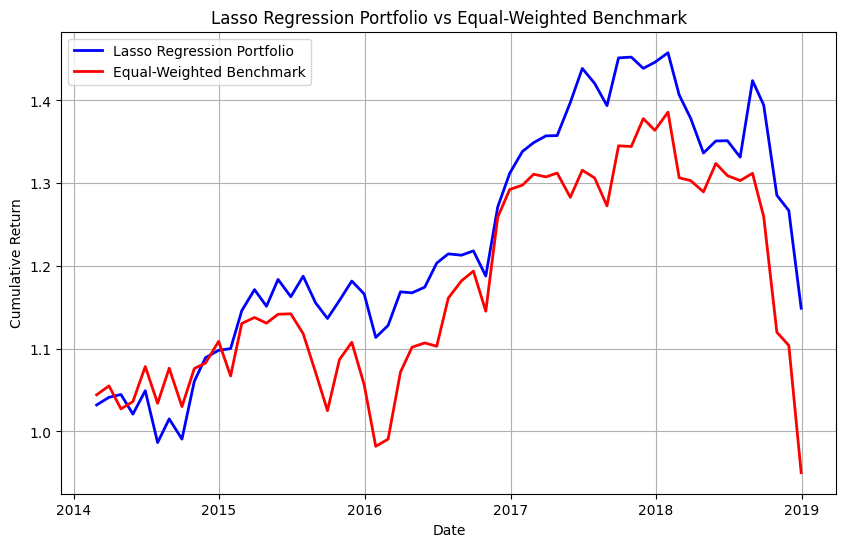

In [7]:
df_ret = df.loc[df_all.index[0]:].drop("label", axis=1)  # Align returns DataFrame with weights DataFrame
df_port_returns = df_all * df_ret.values  # Calculate portfolio returns
df_port_returns["monthly_returns"] = df_port_returns.sum(axis=1)  # Calculate monthly returns
df_port_returns["monthly_compounded_regression_portfolio_return"] = (df_port_returns["monthly_returns"] + 1).cumprod()

# Calculate equal-weighted benchmark returns
df_port_returns["monthly_returns_bench_equal"] = df_ret.mean(axis=1)
df_port_returns["monthly_compounded_bench_equal_return"] = (df_port_returns["monthly_returns_bench_equal"] + 1).cumprod()

# Plot the cumulative returns for the regression-based portfolio and the equal-weighted benchmark
plt.figure(figsize=(10, 6))
plt.plot(df_port_returns.index, df_port_returns["monthly_compounded_regression_portfolio_return"], 
         color='b', lw=2.0, label=f"{reg_type} Regression Portfolio")
plt.plot(df_port_returns.index, df_port_returns["monthly_compounded_bench_equal_return"], 
         color='r', lw=2.0, label="Equal-Weighted Benchmark")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title(f"{reg_type} Regression Portfolio vs Equal-Weighted Benchmark")
plt.legend()
plt.grid(True)
plt.show()

## Modern Portfolio Theory

In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [14]:
github_p = "https://raw.githubusercontent.com/Finance-Notes/Finance-781/main/Lecture%203/"

my_file = Path("data/returns.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('data/returns.csv')
    rf = pd.read_csv('data/rf.csv')
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'data/returns.csv')
    rf = pd.read_csv(github_p+'data/rf.csv')
    
    print("Done")
df = df.set_index("date",drop=True)

# Randomly select 5 columns
selected_columns = df.columns.to_series().sample(n=5).tolist()

df = df[selected_columns]

df.head()

Be patient: loading from github (2 minutes)
Done


,SBNY,HAYN,FSS,DK,TLF
date,,,,,
20071231,-0.089069,-0.177612,-0.019130,0.097072,-0.202439
20080131,-0.007111,-0.364317,0.032977,-0.187840,-0.103976
20080229,-0.209191,0.285876,0.041415,-0.037279,-0.078498
20080331,-0.037736,-0.033973,0.161558,-0.197085,-0.014815
20080430,0.034510,0.141582,-0.005731,-0.129440,0.075188


#### Generate Random Portfolios

In [15]:
# Calculate mean returns and covariance matrix
mean_returns = df.mean()
cov_matrix = df.cov()

# Number of portfolios to simulate
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    # Generate random weights for the portfolio
    weights = np.random.random(len(df.columns))
    weights /= np.sum(weights)
    
    # Calculate portfolio return and volatility
    portfolio_return = np.sum(weights * mean_returns) * 12  # Annualized return
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))  # Annualized volatility
    
    # Record the results
    results[0,i] = portfolio_stddev
    results[1,i] = portfolio_return
    results[2,i] = results[1,i] / results[0,i]  # Sharpe Ratio
    
    # Save the weights
    weights_record.append(weights)

#### Define Functions for Optimization

In [16]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns) * 12
    stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
    return stddev, returns

def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

# Constraints and bounds
def get_optimization_results(mean_returns, cov_matrix, target_return):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_annualized_performance(x, mean_returns, cov_matrix)[1] - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    result = minimize(minimize_volatility, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result


#### Calculate the Efficient Frontier

In [17]:
target_returns = np.linspace(2*(results[1,:].min()+results[1,:].max())/5, results[1,:].max(), 100)
efficient_portfolios = []

for target in target_returns:
    efficient_portfolios.append(get_optimization_results(mean_returns, cov_matrix, target))

# Extract the efficient frontier
efficient_volatility = [p['fun'] for p in efficient_portfolios]
efficient_returns = target_returns


#### Plot the Efficient Frontier

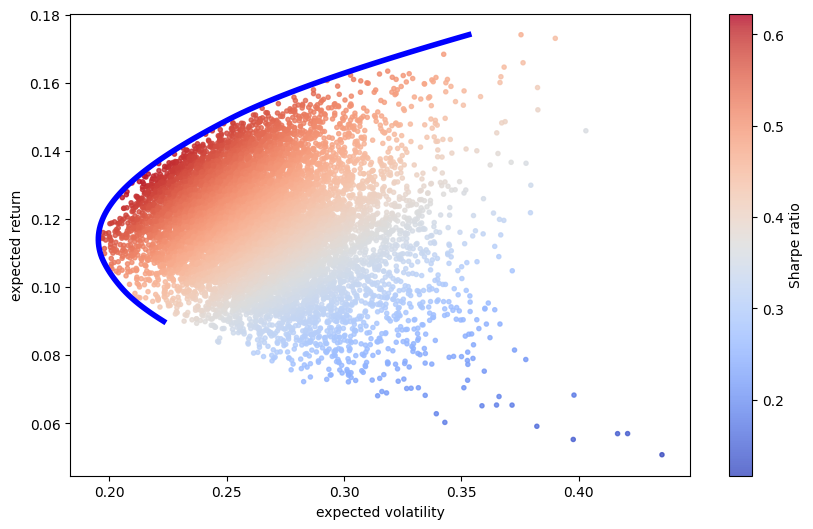

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(results[0,:], results[1,:], c=results[2,:],
            marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(efficient_volatility, efficient_returns, 'b', lw=4.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')